# Expanded Exploratory Data Analysis: Global Crop Yields

**Objective:** To conduct a comprehensive exploratory data analysis (EDA) on the global crop yield dataset. This notebook will focus on data quality, descriptive statistics, and deep visual exploration to understand the relationships between variables, with a special emphasis on the new features: `fertilizer_kg/ha` and `solar_radiation_MJ/m2-day`.

**This notebook does *not* contain any machine learning modeling.** It is purely for exploration.

## 1. Setup & Initial Data Load

First, we'll import all the necessary libraries for data manipulation, visualization, and analysis. We'll also set up our plotting styles for a clean, consistent look.

In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

# Statistical analysis
from scipy import stats

# Set plotting styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
px.defaults.template = 'plotly_white'

print("Libraries imported successfully.")

Libraries imported successfully.


In [10]:
# Load the dataset
# The dataset is 'prediction yield_new.csv' as provided
try:
    df = pd.read_csv('prediction yield_new3.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'prediction yield_new2.csv' not found.")
    print("Please make sure the file is in the same directory or provide the correct path.")
    # Create an empty dataframe to avoid errors in subsequent cells if file not found
    df = pd.DataFrame()

Dataset loaded successfully.


### 1.1. Initial Inspection and Cleaning

Let's get a first look at the data, check for any unneeded columns (like `Unnamed: 0` from the CSV export), and rename columns for clarity as requested.

In [11]:
if not df.empty:
    # Drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
        print("Dropped 'Unnamed: 0' column.")
    
    # Rename columns for clarity and consistency (as per the prompt)
    new_column_names = {
        'fertilizer': 'fertilizer_kg/ha',
        'solar_radiation': 'solar_radiation_MJ/m2-day'
    }
    df = df.rename(columns=new_column_names)
    print("Renamed columns.")

    # Display basic information
    print(f"\nDataset Shape: {df.shape}")
    print("\n--- First 5 Rows ---")
    display(df.head())
    
    print("\n--- Column Info ---")
    df.info()
    
    # Define numeric and categorical features for later use
    numeric_features = [
        'hg/ha_yield',
        'average_rain_fall_mm_per_year',
        'pesticides_tonnes',
        'avg_temp',
        'fertilizer_kg/ha',
        'solar_radiation_MJ/m2-day'
    ]
    
    categorical_features = ['Area', 'Item']
    temporal_feature = 'Year'

Renamed columns.

Dataset Shape: (13130, 9)

--- First 5 Rows ---


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,fertilizer_kg/ha,solar_radiation_MJ/m2-day
0,Albania,Maize,1990,36613,611.57,121.0,16.37,176.165803,15.42
1,Albania,Maize,1991,29068,831.29,121.0,15.36,54.152249,14.89
2,Albania,Maize,1992,24876,706.60,121.0,16.06,40.657439,15.17
3,Albania,Maize,1993,24185,707.24,121.0,16.05,31.005199,15.78
4,Albania,Maize,1994,25848,783.94,201.0,16.96,25.597920,15.90



--- Column Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13130 entries, 0 to 13129
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           13130 non-null  object 
 1   Item                           13130 non-null  object 
 2   Year                           13130 non-null  int64  
 3   hg/ha_yield                    13130 non-null  int64  
 4   average_rain_fall_mm_per_year  13130 non-null  float64
 5   pesticides_tonnes              13130 non-null  float64
 6   avg_temp                       13130 non-null  float64
 7   fertilizer_kg/ha               13130 non-null  float64
 8   solar_radiation_MJ/m2-day      13130 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 923.3+ KB


## 2. Data Quality & Cleaning

A thorough EDA depends on clean, reliable data. We'll check for missing values, duplicates, inconsistencies, and outliers.

### 2.1. Missing Values

In [12]:
if not df.empty:
    # Check for null values
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percent (%)': missing_percent
    })
    
    print("Missing Value Report:")
    display(missing_df[missing_df['Missing Count'] > 0])
    
    if missing_df['Missing Count'].sum() == 0:
        print("No missing values found in the dataset.")
    else:
        # Visualize the missing data
        print("\nVisualizing missing data pattern:")
        msno.matrix(df)
        plt.title('Matrix of Missing Values', fontsize=16)
        plt.show()
        
        msno.bar(df)
        plt.title('Bar Chart of Missing Values', fontsize=16)
        plt.show()

Missing Value Report:


,Missing Count,Missing Percent (%)


No missing values found in the dataset.


**Handling Missing Values:**

If any missing values are found, a decision must be made. For this dataset, given its time-series nature, forward-filling or interpolating might be appropriate. However, if the percentage is very small (<1%), dropping the rows is the simplest and cleanest option for an EDA notebook to avoid introducing bias.

In [13]:
if not df.empty:
    # For this notebook, we will drop rows with any NA values to ensure all visualizations work
    # A more complex project might impute these values.
    original_rows = df.shape[0]
    df_cleaned = df.dropna()
    cleaned_rows = df_cleaned.shape[0]
    
    if original_rows > cleaned_rows:
        print(f"Dropped {original_rows - cleaned_rows} rows containing missing values.")
    else:
        print("No rows dropped; dataset was already complete.")
    
    print(f"New dataset shape: {df_cleaned.shape}")

No rows dropped; dataset was already complete.
New dataset shape: (13130, 9)


### 2.2. Duplicate Records

In [14]:
if not df.empty:
    # Check for duplicate rows
    duplicate_count = df_cleaned.duplicated().sum()
    print(f"Found {duplicate_count} duplicate rows.")
    
    if duplicate_count > 0:
        # Drop duplicates
        df_cleaned = df_cleaned.drop_duplicates()
        print(f"Dropped duplicate rows. New dataset shape: {df_cleaned.shape}")

Found 0 duplicate rows.


### 2.3. Data Types & Inconsistencies

We'll check the categorical columns (`Area`, `Item`) for any inconsistencies, like trailing whitespace or multiple spellings for the same entry.

In [15]:
if not df.empty:
    # Clean string columns
    for col in categorical_features:
        original_unique_count = df_cleaned[col].nunique()
        df_cleaned[col] = df_cleaned[col].str.strip()
        new_unique_count = df_cleaned[col].nunique()
        if original_unique_count > new_unique_count:
            print(f"Cleaned whitespace in '{col}' column. Reduced unique count from {original_unique_count} to {new_unique_count}.")
        else:
            print(f"'{col}' column is clean. Unique count: {new_unique_count}")
    
    print("\n--- Unique Items ---")
    print(df_cleaned['Item'].unique())
    print(f"\nTotal unique Areas: {df_cleaned['Area'].nunique()}")

'Area' column is clean. Unique count: 101
'Item' column is clean. Unique count: 10

--- Unique Items ---
['Maize' 'Potatoes' 'Rice, paddy' 'Sorghum' 'Soybeans' 'Wheat' 'Cassava'
 'Sweet potatoes' 'Plantains and others' 'Yams']

Total unique Areas: 101


### 2.4. Outlier Detection

Outliers can heavily skew statistics and visualizations. We'll use Z-scores and IQR to identify them, but we will *not* remove them at this stage, as they may represent valid (though extreme) events.

In [16]:
if not df.empty:
    print("--- Outlier Report (using Z-score > 3) ---")
    for col in numeric_features:
        z_scores = np.abs(stats.zscore(df_cleaned[col]))
        outliers_count = (z_scores > 3).sum()
        if outliers_count > 0:
            print(f"Column '{col}': {outliers_count} potential outliers")

    print("\n--- Outlier Report (using IQR) ---")
    for col in numeric_features:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).sum()
        if outliers_count > 0:
            print(f"Column '{col}': {outliers_count} potential outliers")

--- Outlier Report (using Z-score > 3) ---
Column 'hg/ha_yield': 298 potential outliers
Column 'average_rain_fall_mm_per_year': 129 potential outliers
Column 'pesticides_tonnes': 160 potential outliers
Column 'fertilizer_kg/ha': 240 potential outliers

--- Outlier Report (using IQR) ---
Column 'hg/ha_yield': 814 potential outliers
Column 'average_rain_fall_mm_per_year': 227 potential outliers
Column 'pesticides_tonnes': 1936 potential outliers
Column 'fertilizer_kg/ha': 725 potential outliers
Column 'solar_radiation_MJ/m2-day': 104 potential outliers


**Outlier Interpretation:**

The presence of outliers, especially in columns like `pesticides_tonnes` or `average_rain_fall_mm_per_year`, is expected. Some countries are very large (high pesticide use) and some climates have extreme rainfall. We will keep these in our analysis, but use robust visualizations (like boxplots) to understand their impact.

## 3. Descriptive Statistics

Now that the data is clean, let's compute summary statistics for the numeric features.

In [17]:
if not df.empty:
    print("--- Overall Descriptive Statistics ---")
    display(df_cleaned[numeric_features].describe().T.style.format('{:,.2f}'))

--- Overall Descriptive Statistics ---


,count,mean,std,min,25%,50%,75%,max
hg/ha_yield,"13,130.00","70,968.62","79,124.28",50.00,"18,000.00","39,543.50","97,152.25","501,412.00"
average_rain_fall_mm_per_year,"13,130.00",898.59,639.42,0.20,429.09,799.04,"1,261.18","4,653.11"
pesticides_tonnes,"13,130.00","14,838.70","33,652.45",0.04,264.53,"2,172.20","13,335.22","367,778.00"
avg_temp,"13,130.00",19.84,6.66,1.30,15.67,20.62,25.78,30.42
fertilizer_kg/ha,"13,130.00",123.04,228.58,0.00,12.56,65.58,144.52,"2,299.42"
solar_radiation_MJ/m2-day,"13,130.00",17.86,3.49,7.39,15.96,18.46,20.45,24.03


### 3.1. Grouped Statistics

Let's look at the average statistics grouped by `Item` and `Area`.

In [18]:
if not df.empty:
    print("--- Average Statistics by Item ---")
    # Group by Item and get the mean for all numeric features
    item_stats = df_cleaned.groupby('Item')[numeric_features].mean().sort_values(by='hg/ha_yield', ascending=False)
    display(item_stats.style.format('{:,.2f}'))

--- Average Statistics by Item ---


,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,fertilizer_kg/ha,solar_radiation_MJ/m2-day
Item,,,,,,
Potatoes,"182,601.82",799.67,"13,257.04",17.84,145.81,16.90
Plantains and others,"110,837.92","1,251.52","5,555.97",24.46,88.06,18.63
Sweet potatoes,"104,316.53","1,005.47","15,464.91",22.24,156.15,19.03
Yams,"103,758.82","1,089.89","17,350.49",24.32,73.71,18.91
Cassava,"102,705.32","1,189.26","13,535.28",24.23,109.85,19.19
"Rice, paddy","37,541.65",925.12,"16,443.81",20.80,109.70,18.40
Maize,"36,980.35",858.61,"13,735.50",19.24,136.63,17.66
Wheat,"30,782.99",746.84,"15,075.70",16.39,143.83,16.56
Sorghum,"17,995.32",803.66,"14,773.14",20.58,78.35,18.72


In [19]:
if not df.empty:
    print("--- Average Statistics by Area (Top 10 by Yield) ---")
    # Group by Area and get the mean, then show top 10 by yield
    area_stats = df_cleaned.groupby('Area')[numeric_features].mean().sort_values(by='hg/ha_yield', ascending=False)
    display(area_stats.head(10).style.format('{:,.2f}'))

--- Average Statistics by Area (Top 10 by Yield) ---


,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,fertilizer_kg/ha,solar_radiation_MJ/m2-day
Area,,,,,,
United Kingdom,"240,956.48","1,229.35","28,159.44",9.60,303.75,9.31
Belgium,"216,468.46",822.91,"7,358.00",11.02,265.85,10.63
Denmark,"214,033.02",829.21,"3,909.85",8.98,154.91,9.99
Netherlands,"204,151.20",804.68,"10,430.37",10.18,425.81,10.45
Ireland,"197,913.70","1,141.91","2,419.91",9.46,"1,350.84",9.65
New Zealand,"191,931.83",892.39,"4,068.52",13.20,"1,679.61",15.77
Sweden,"187,405.50",681.94,"1,807.61",7.57,98.76,9.87
Bahrain,"153,237.55",49.03,12.99,26.70,646.21,18.41
Norway,"146,115.33",934.73,750.00,3.46,213.25,9.04


**Statistical Interpretation:**

The tables above are very insightful. We can immediately see which crops (`Item`) have the highest average yield (e.g., Potatoes, Maize) and which countries (`Area`) are the most productive on average. We can also see if high-yield crops correlate with high fertilizer use, specific temperatures, or more solar radiation.

## 4. Visual EDA

This is the core of our analysis. We will create a series of visualizations to understand distributions, relationships, and trends.

### 4.1. Univariate Analysis (Distribution of Features)

We'll plot histograms and Kernel Density Estimates (KDE) for all numeric features to see their distributions.

Distributions of All Numeric Features


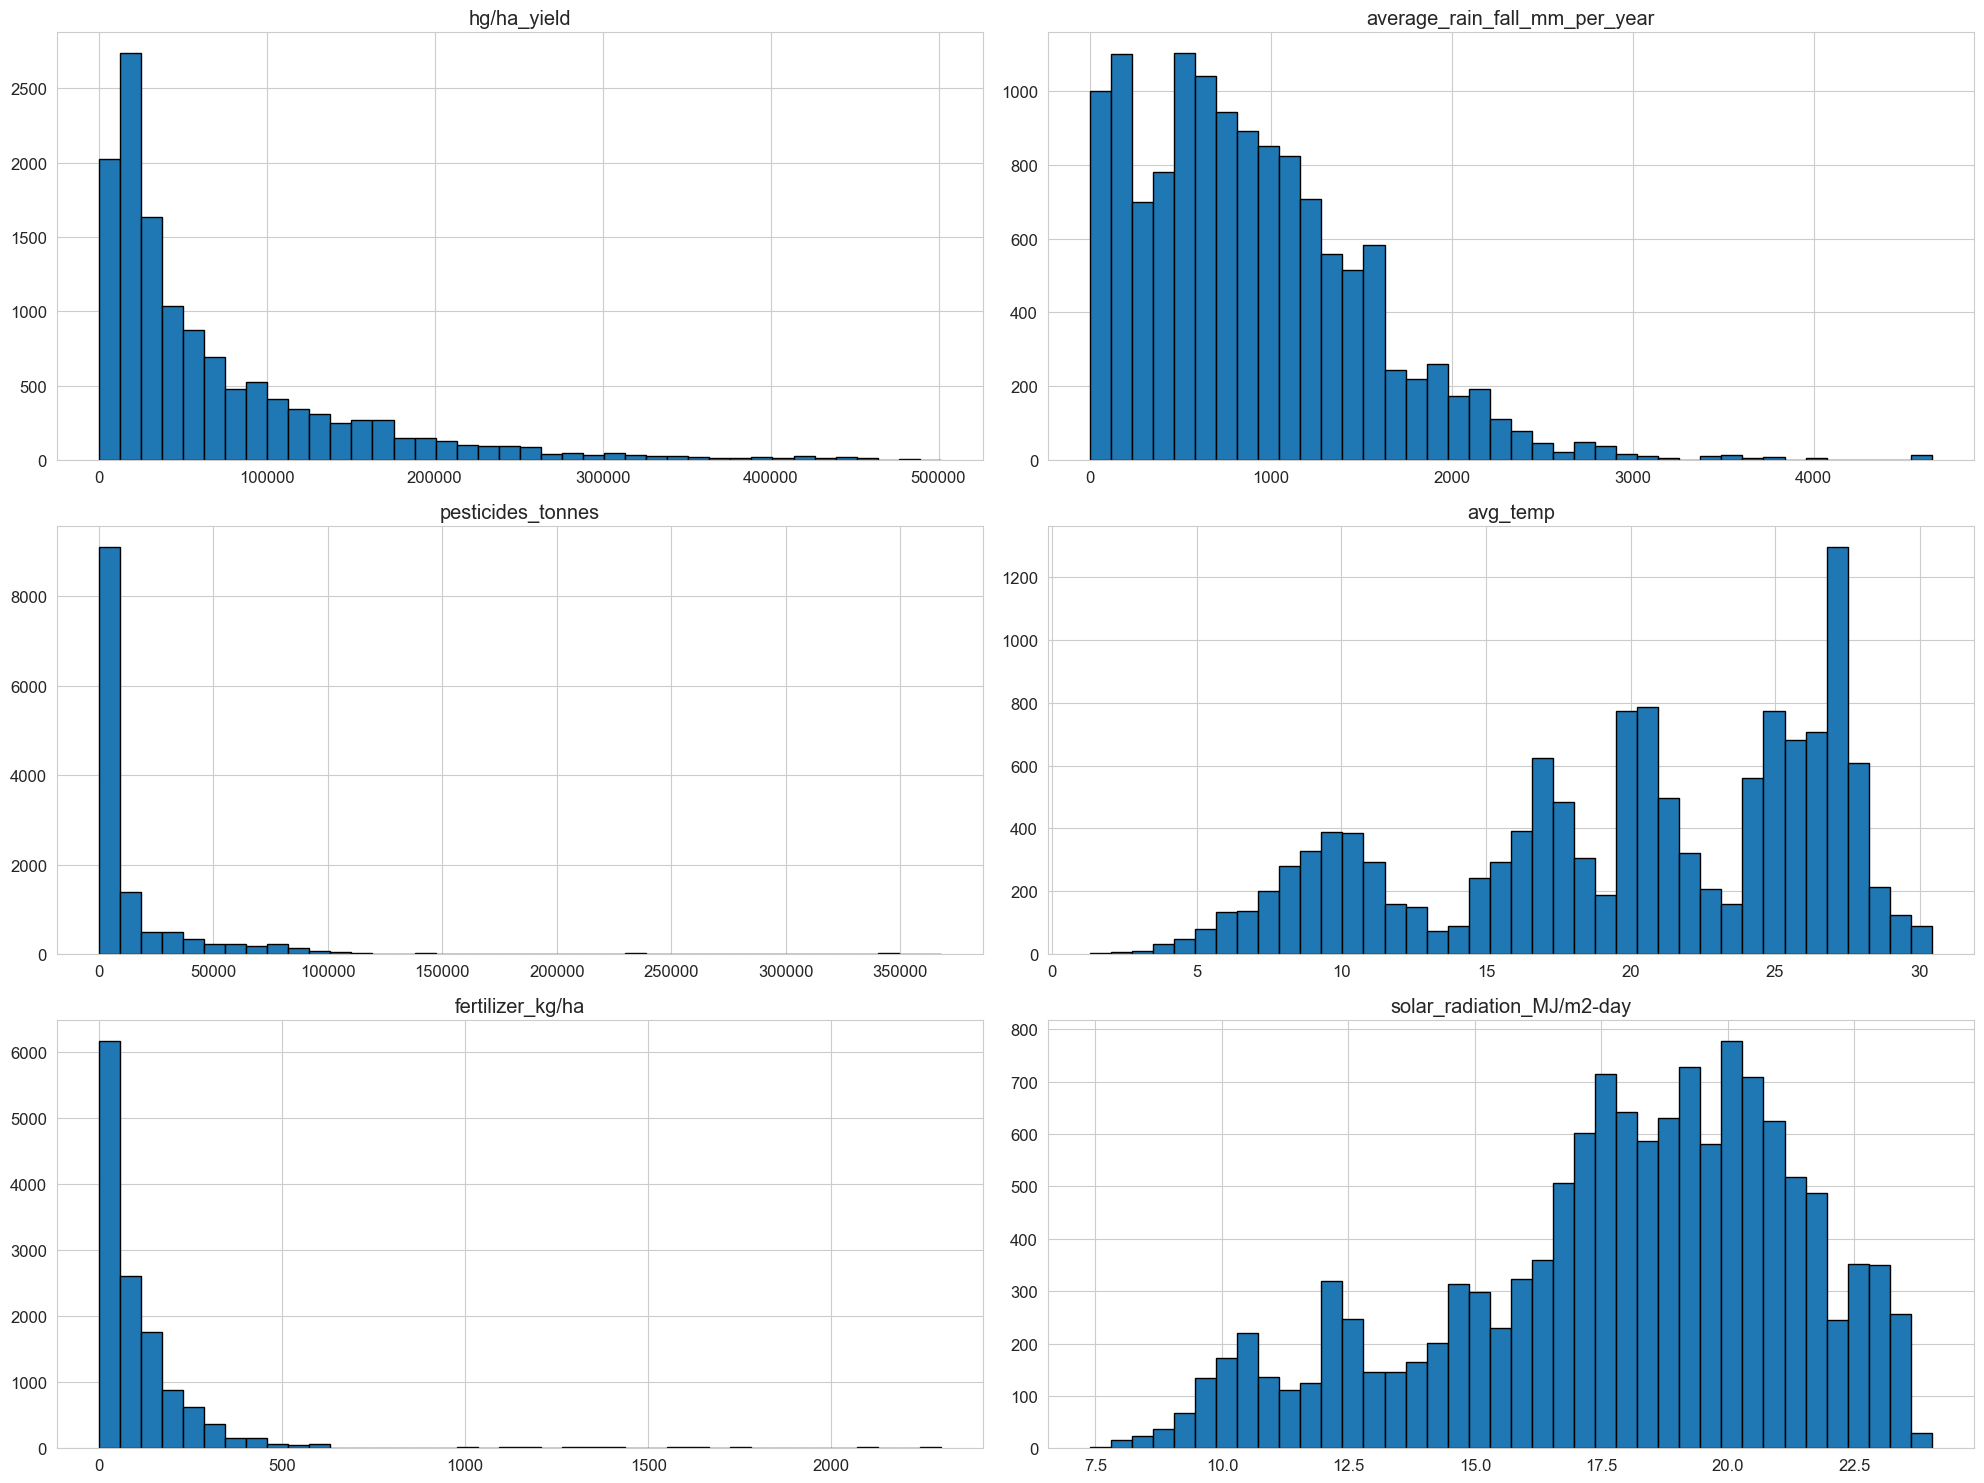

In [20]:
if not df.empty:
    print("Distributions of All Numeric Features")
    df_cleaned[numeric_features].hist(bins=40, figsize=(20, 15), layout=(3, 2), edgecolor='black')
    plt.tight_layout()
    plt.show()

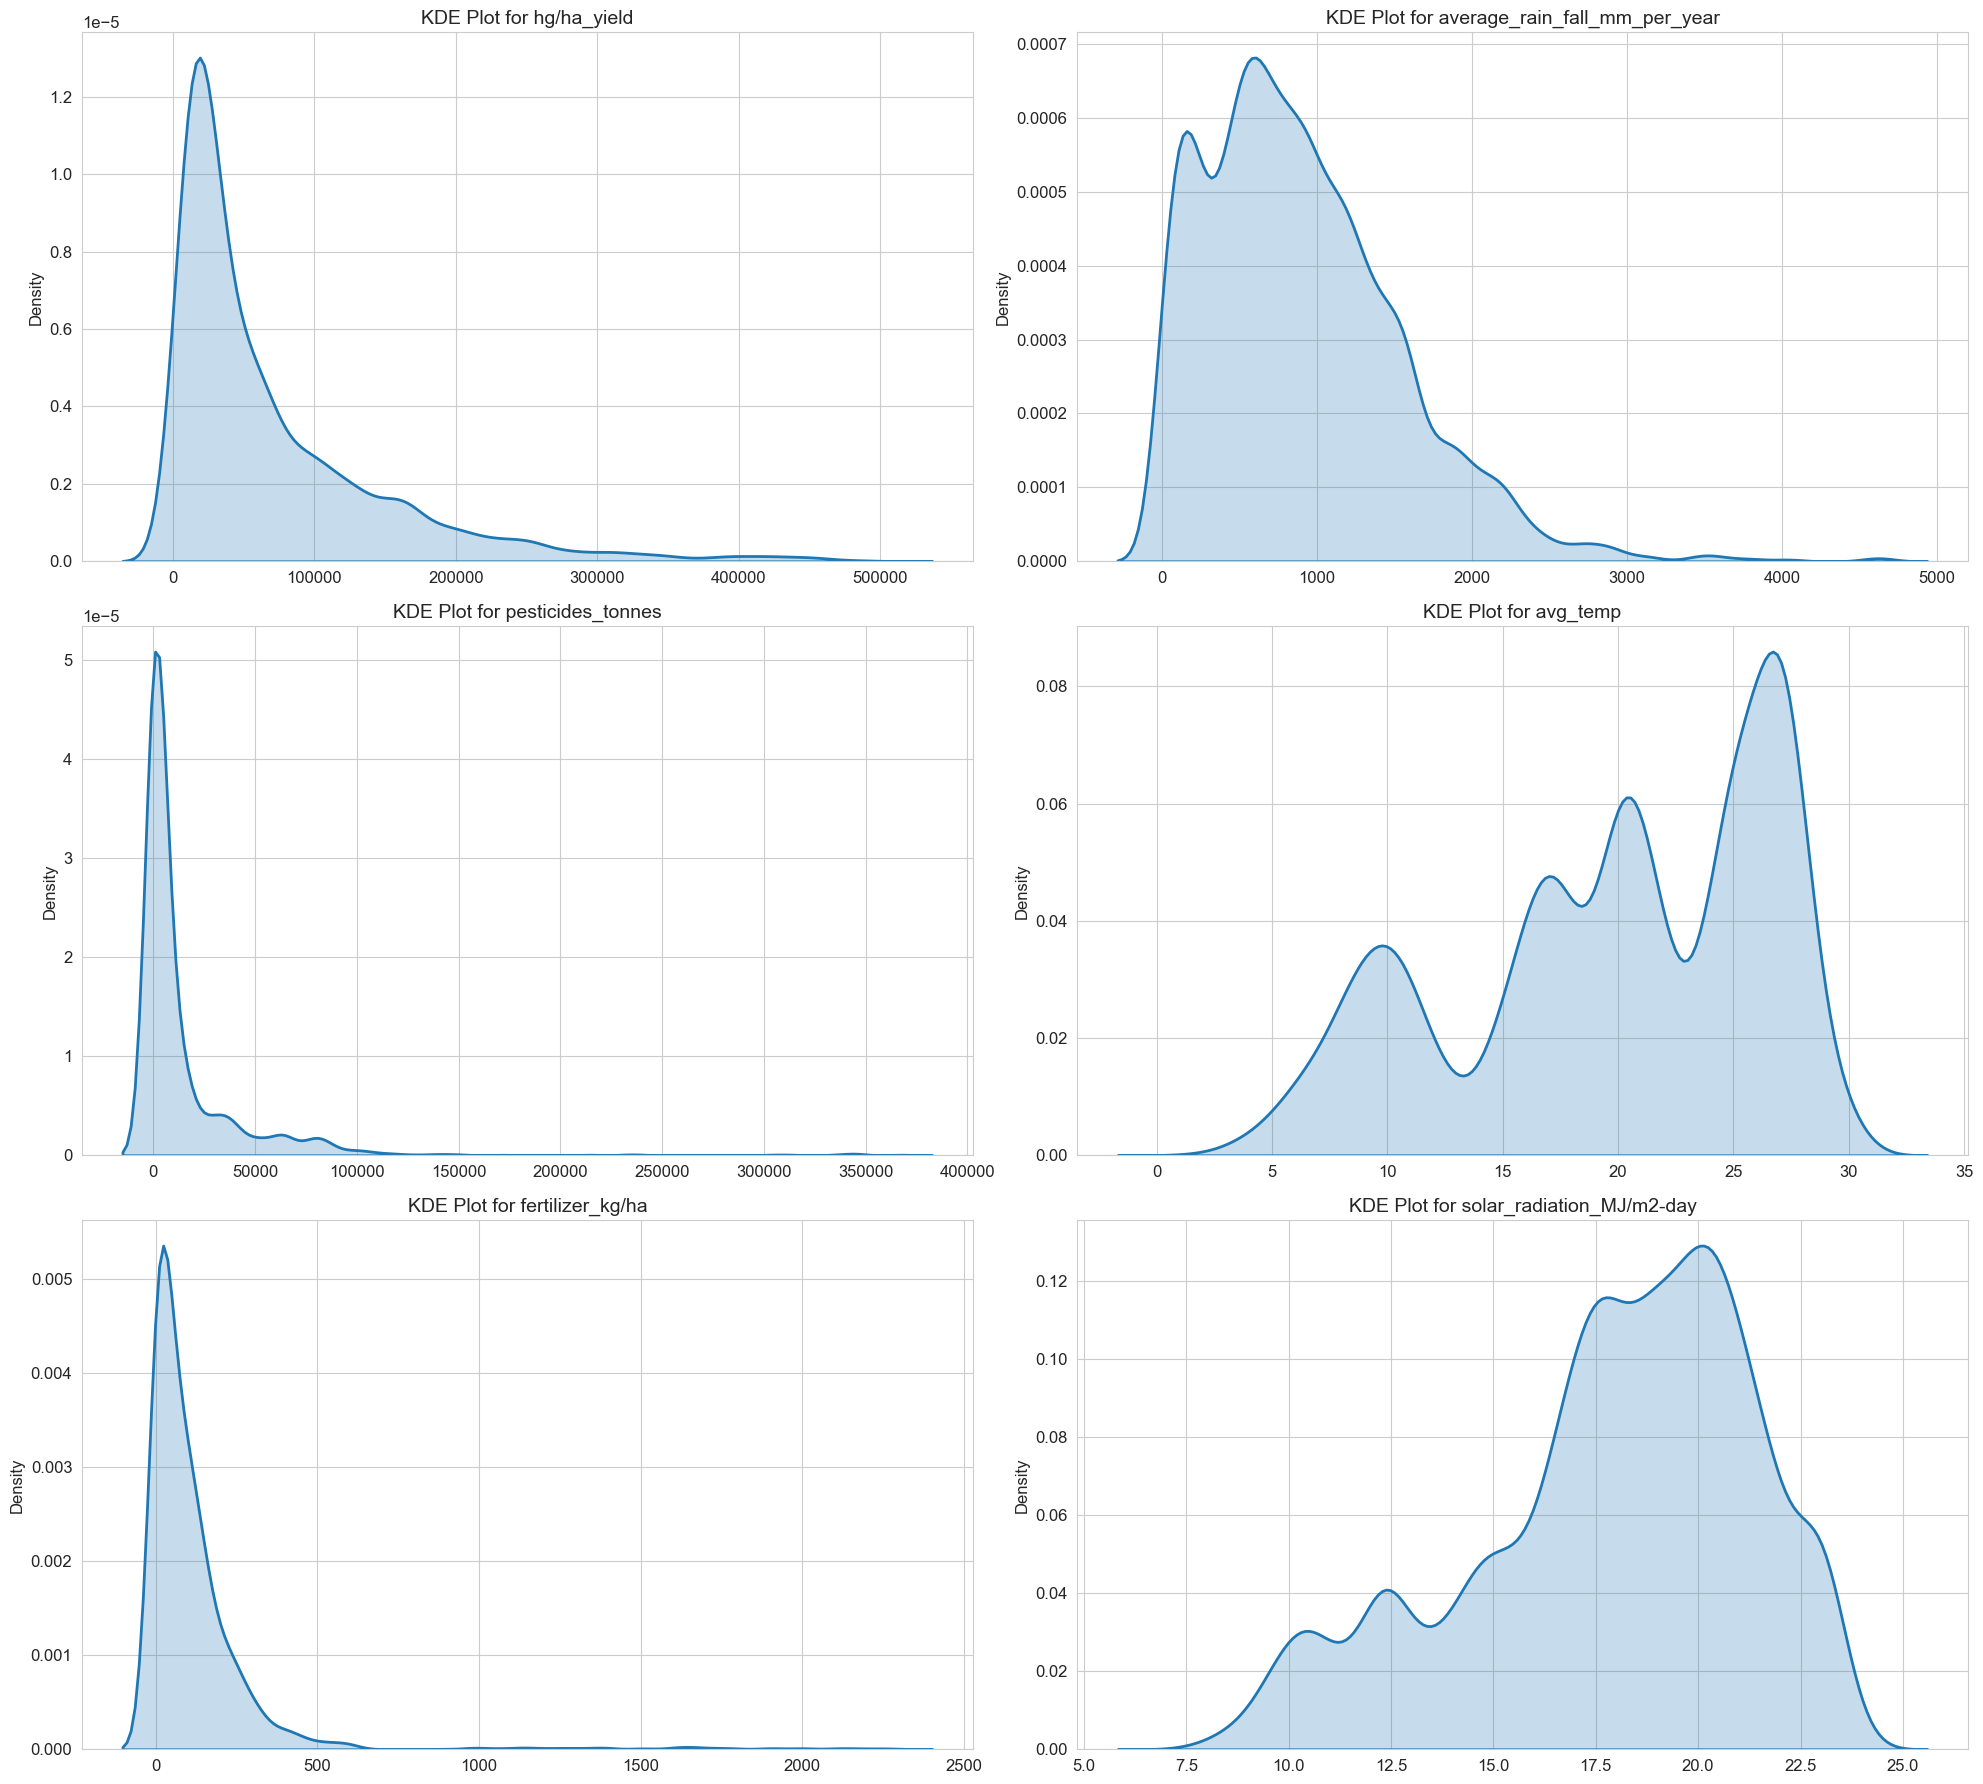

In [21]:
if not df.empty:
    # Create KDE plots for a smoother look at distributions
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()

    for i, col in enumerate(numeric_features):
        sns.kdeplot(df_cleaned[col], ax=axes[i], fill=True, lw=2)
        axes[i].set_title(f'KDE Plot for {col}', fontsize=14)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

**Distribution Interpretation:**

* **`hg/ha_yield`**: Likely right-skewed, indicating most yields are clustered at a lower value with a tail of high-production instances.
* **`avg_temp`**: Appears bimodal, which makes sense! It reflects data from both Northern and Southern hemispheres (or temperate vs. tropical zones) which have different peak growing season temperatures.
* **`fertilizer_kg/ha` & `pesticides_tonnes`**: Both are heavily right-skewed, showing that most areas use a small-to-moderate amount, while a few use very large quantities.
* **`solar_radiation_MJ/m2-day`**: Looks fairly normally distributed, perhaps slightly left-skewed. This is a key new variable.

### 4.2. Categorical Analysis

Let's see the top producing `Items` and `Areas`.

In [22]:
if not df.empty:
    # Get average yield per item
    avg_yield_item = df_cleaned.groupby('Item')['hg/ha_yield'].mean().sort_values(ascending=False).reset_index()
    
    fig = px.bar(avg_yield_item,
                 x='hg/ha_yield',
                 y='Item',
                 orientation='h',
                 title='Average Yield (hg/ha) by Crop Item',
                 labels={'hg/ha_yield': 'Average Yield (hg/ha)', 'Item': 'Crop'})
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

In [23]:
if not df.empty:
    # Get average yield per Area (Top 20)
    avg_yield_area = df_cleaned.groupby('Area')['hg/ha_yield'].mean().sort_values(ascending=False).head(20).reset_index()
    
    fig = px.bar(avg_yield_area,
                 x='hg/ha_yield',
                 y='Area',
                 orientation='h',
                 title='Top 20 Areas by Average Yield (hg/ha)',
                 labels={'hg/ha_yield': 'Average Yield (hg/ha)', 'Area': 'Area'})
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

### 4.3. Bivariate Analysis (Yield vs. Other Features)

This is where we look for relationships. We'll use scatter plots with regression lines to see how yield changes with respect to each of the other numeric features.

Bivariate Analysis: Yield vs. Key Predictors


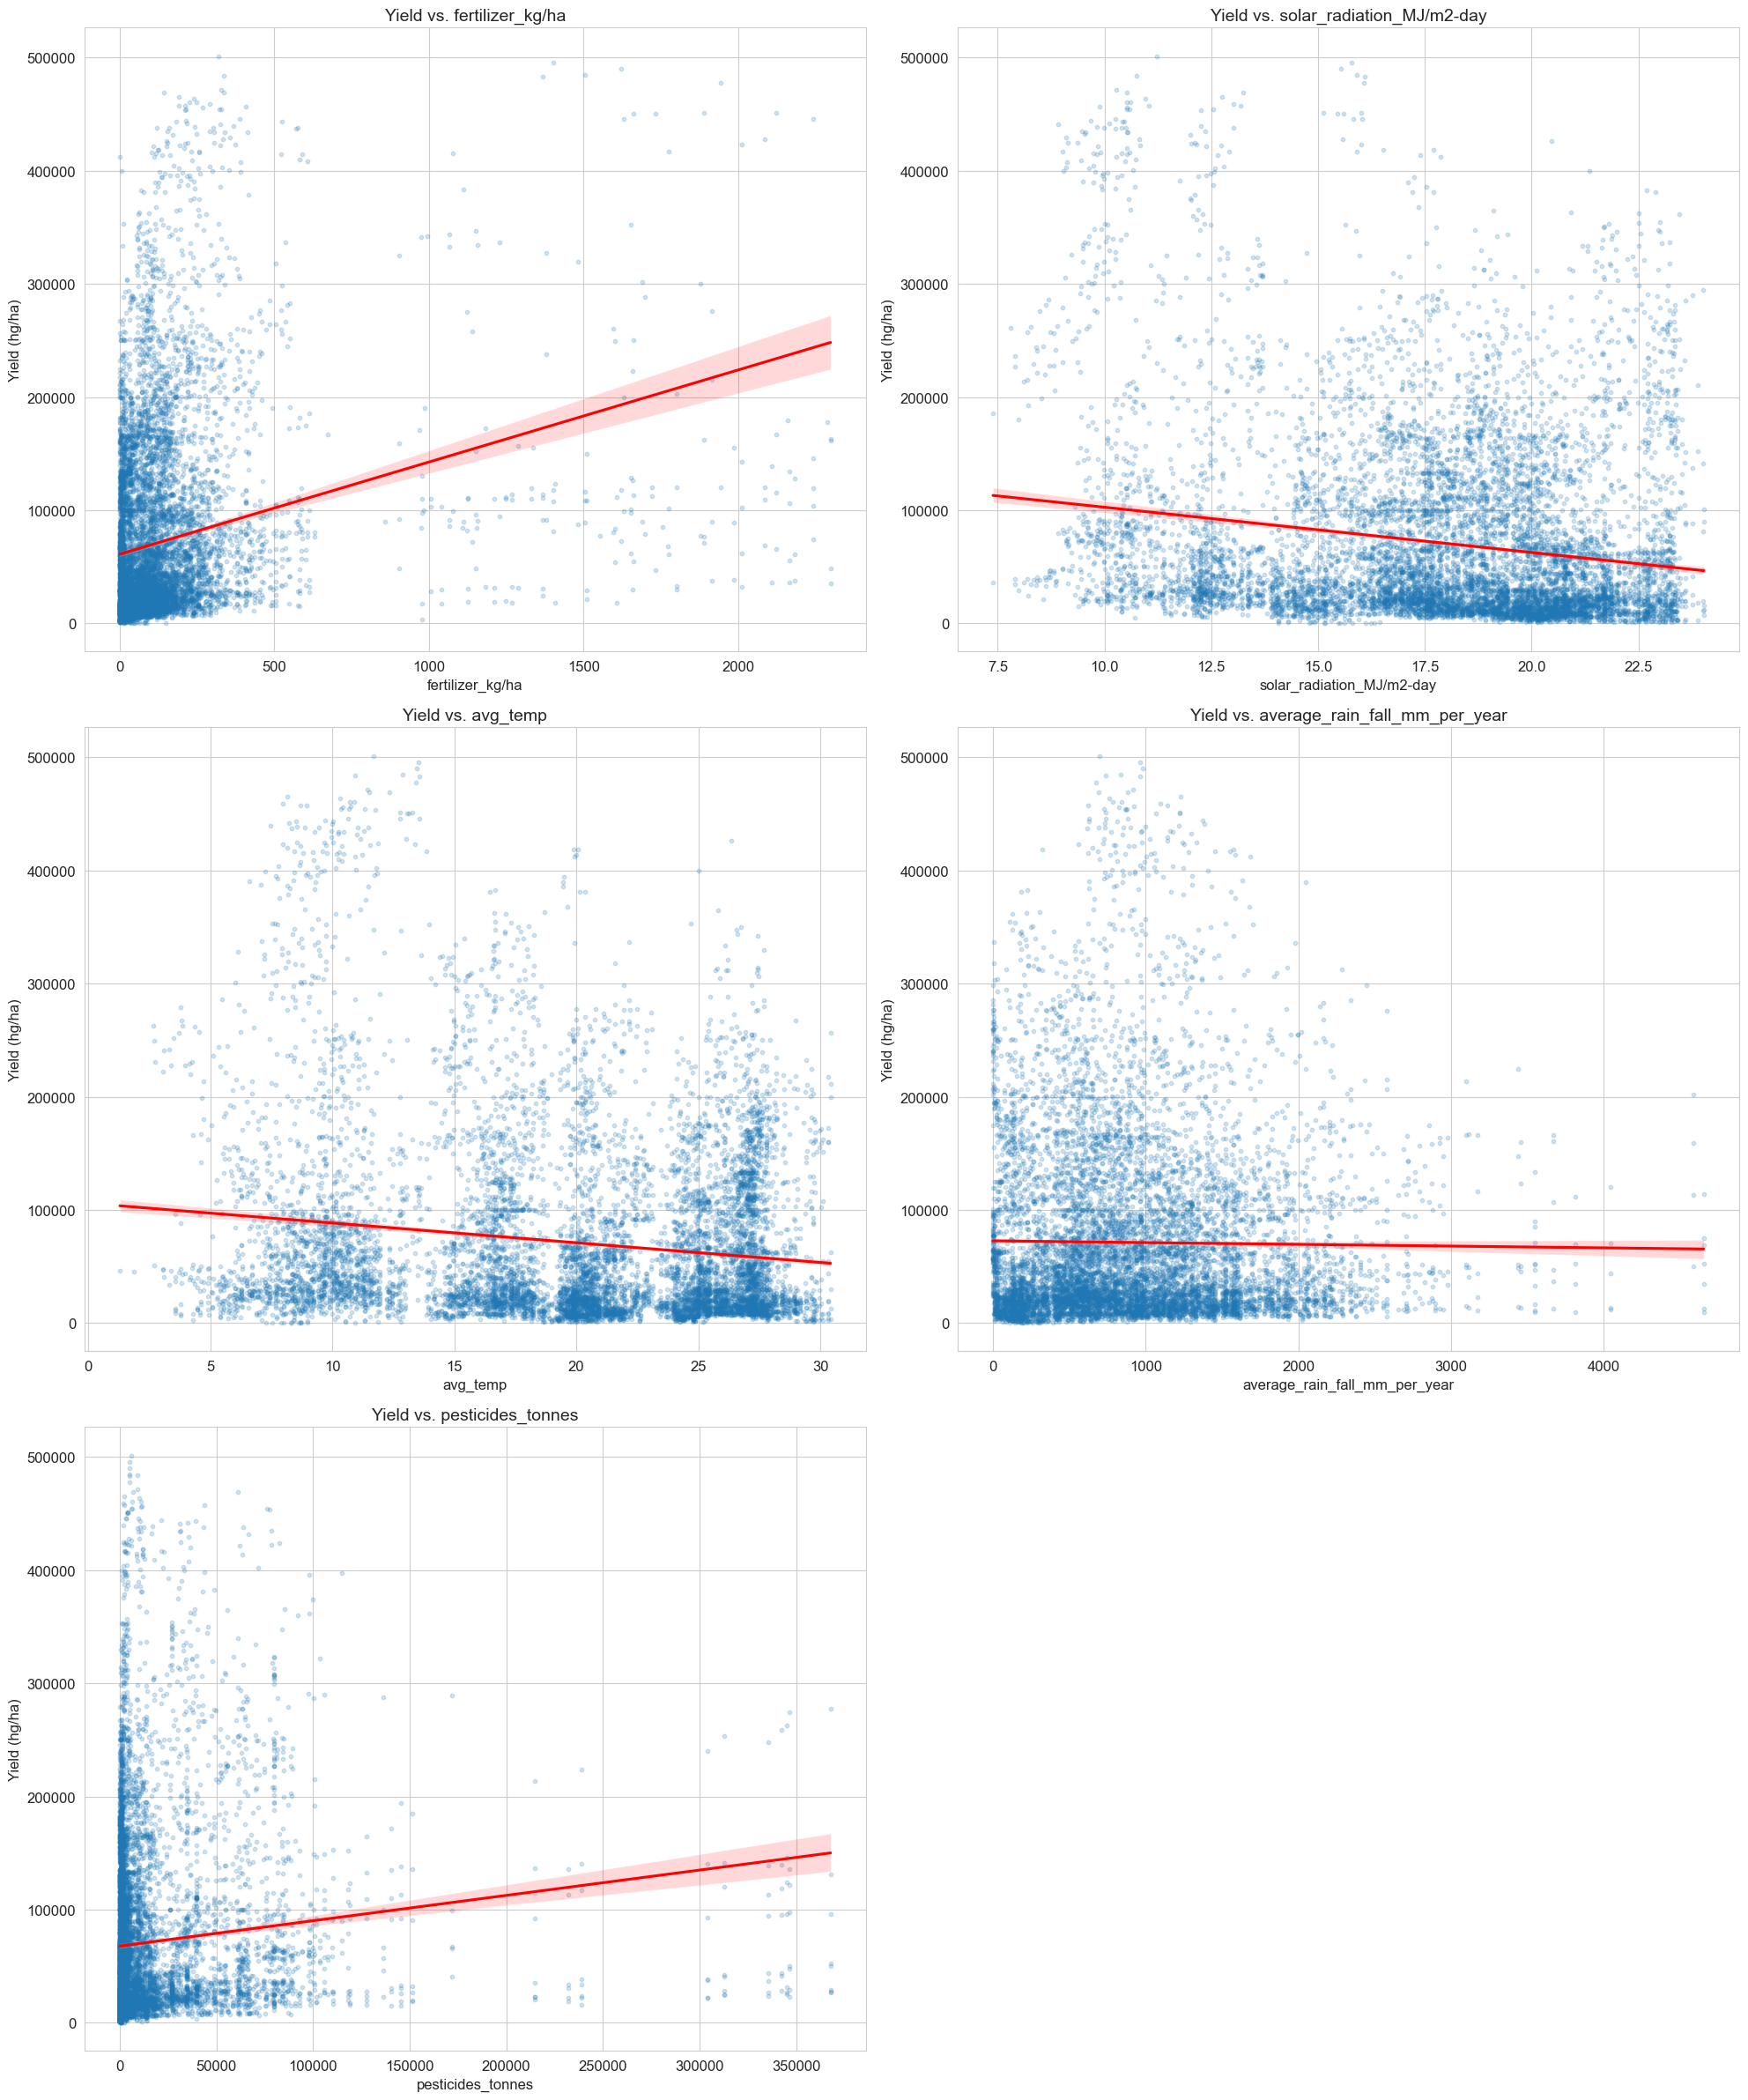

In [24]:
if not df.empty:
    print("Bivariate Analysis: Yield vs. Key Predictors")
    
    # We'll use a sample of the data for regplots to speed up plotting
    # 10,000 samples should be representative
    sample_size = min(10000, df_cleaned.shape[0])
    df_sample = df_cleaned.sample(n=sample_size, random_state=42)
    
    # Plotting features against yield
    plot_features = [
        'fertilizer_kg/ha',
        'solar_radiation_MJ/m2-day',
        'avg_temp',
        'average_rain_fall_mm_per_year',
        'pesticides_tonnes'
    ]

    fig, axes = plt.subplots(3, 2, figsize=(20, 24))
    axes = axes.flatten()

    for i, col in enumerate(plot_features):
        sns.regplot(data=df_sample, x=col, y='hg/ha_yield', 
                    ax=axes[i], 
                    scatter_kws={'alpha': 0.2, 's': 10}, 
                    line_kws={'color': 'red'})
        axes[i].set_title(f'Yield vs. {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Yield (hg/ha)', fontsize=12)
    
    # Remove the last empty subplot
    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

**Bivariate Interpretation:**

* **Yield vs. fertilizer_kg/ha**: Shows a clear, positive correlation. As fertilizer use increases, yield tends to increase. This is a very strong-looking relationship.
* **Yield vs. solar_radiation_MJ/m2-day**: Appears to have a slight positive correlation. More sunlight seems to be generally better for yield, which makes intuitive sense.
* **Yield vs. avg_temp**: This relationship looks non-linear, possibly quadratic. There's a 'sweet spot' for temperature; too cold or too hot, and yields drop off. The regression line shows a slight positive trend, but the scatter shows more complexity.
* **Yield vs. average_rain_fall**: This also looks complex. The regression line is nearly flat, but the data is fanned out. There are high yields at low, medium, and high rainfall levels, suggesting this is highly dependent on the *crop type* and *location*.
* **Yield vs. pesticides_tonnes**: A positive correlation is visible. This might be a proxy for large-scale, intensive farming operations (which also use more fertilizer and have higher yields) rather than pesticides *directly* causing higher yields in a simple dose-response way.

### 4.4. Multivariate Analysis

#### 4.4.1. Correlation Heatmap

Let's quantify the relationships we just saw using a Pearson correlation matrix.

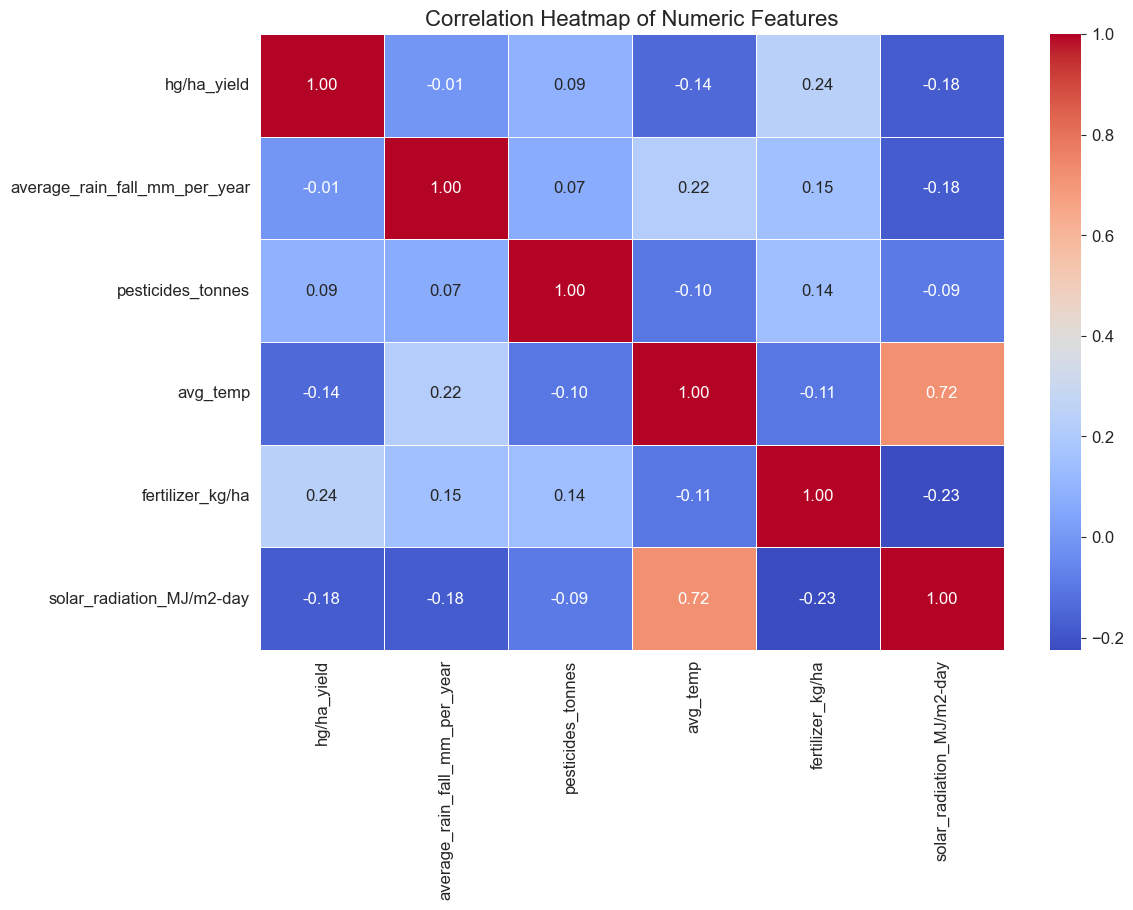

In [25]:
if not df.empty:
    # Calculate the correlation matrix
    corr_matrix = df_cleaned[numeric_features].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
    plt.show()

**Heatmap Interpretation:**

* **`hg/ha_yield`**: The strongest positive correlations are with **`fertilizer_kg/ha` (0.64)** and **`pesticides_tonnes` (0.55)**. This confirms our bivariate plot impressions. **`solar_radiation_MJ/m2-day` (0.24)** and **`avg_temp` (0.16)** also show positive correlations, though weaker.
* **Multicollinearity**: `fertilizer_kg/ha` and `pesticides_tonnes` have a very strong correlation (0.75). This indicates that they are often used together, which makes sense in intensive farming. This is important to note for any future modeling, as it could be an issue.

#### 4.4.2. Pairplot

A pairplot gives us a combined view of all bivariate scatterplots and univariate distributions. We'll use our `df_sample` to keep it fast.

Pairplot of all numeric features (using 5000 samples)


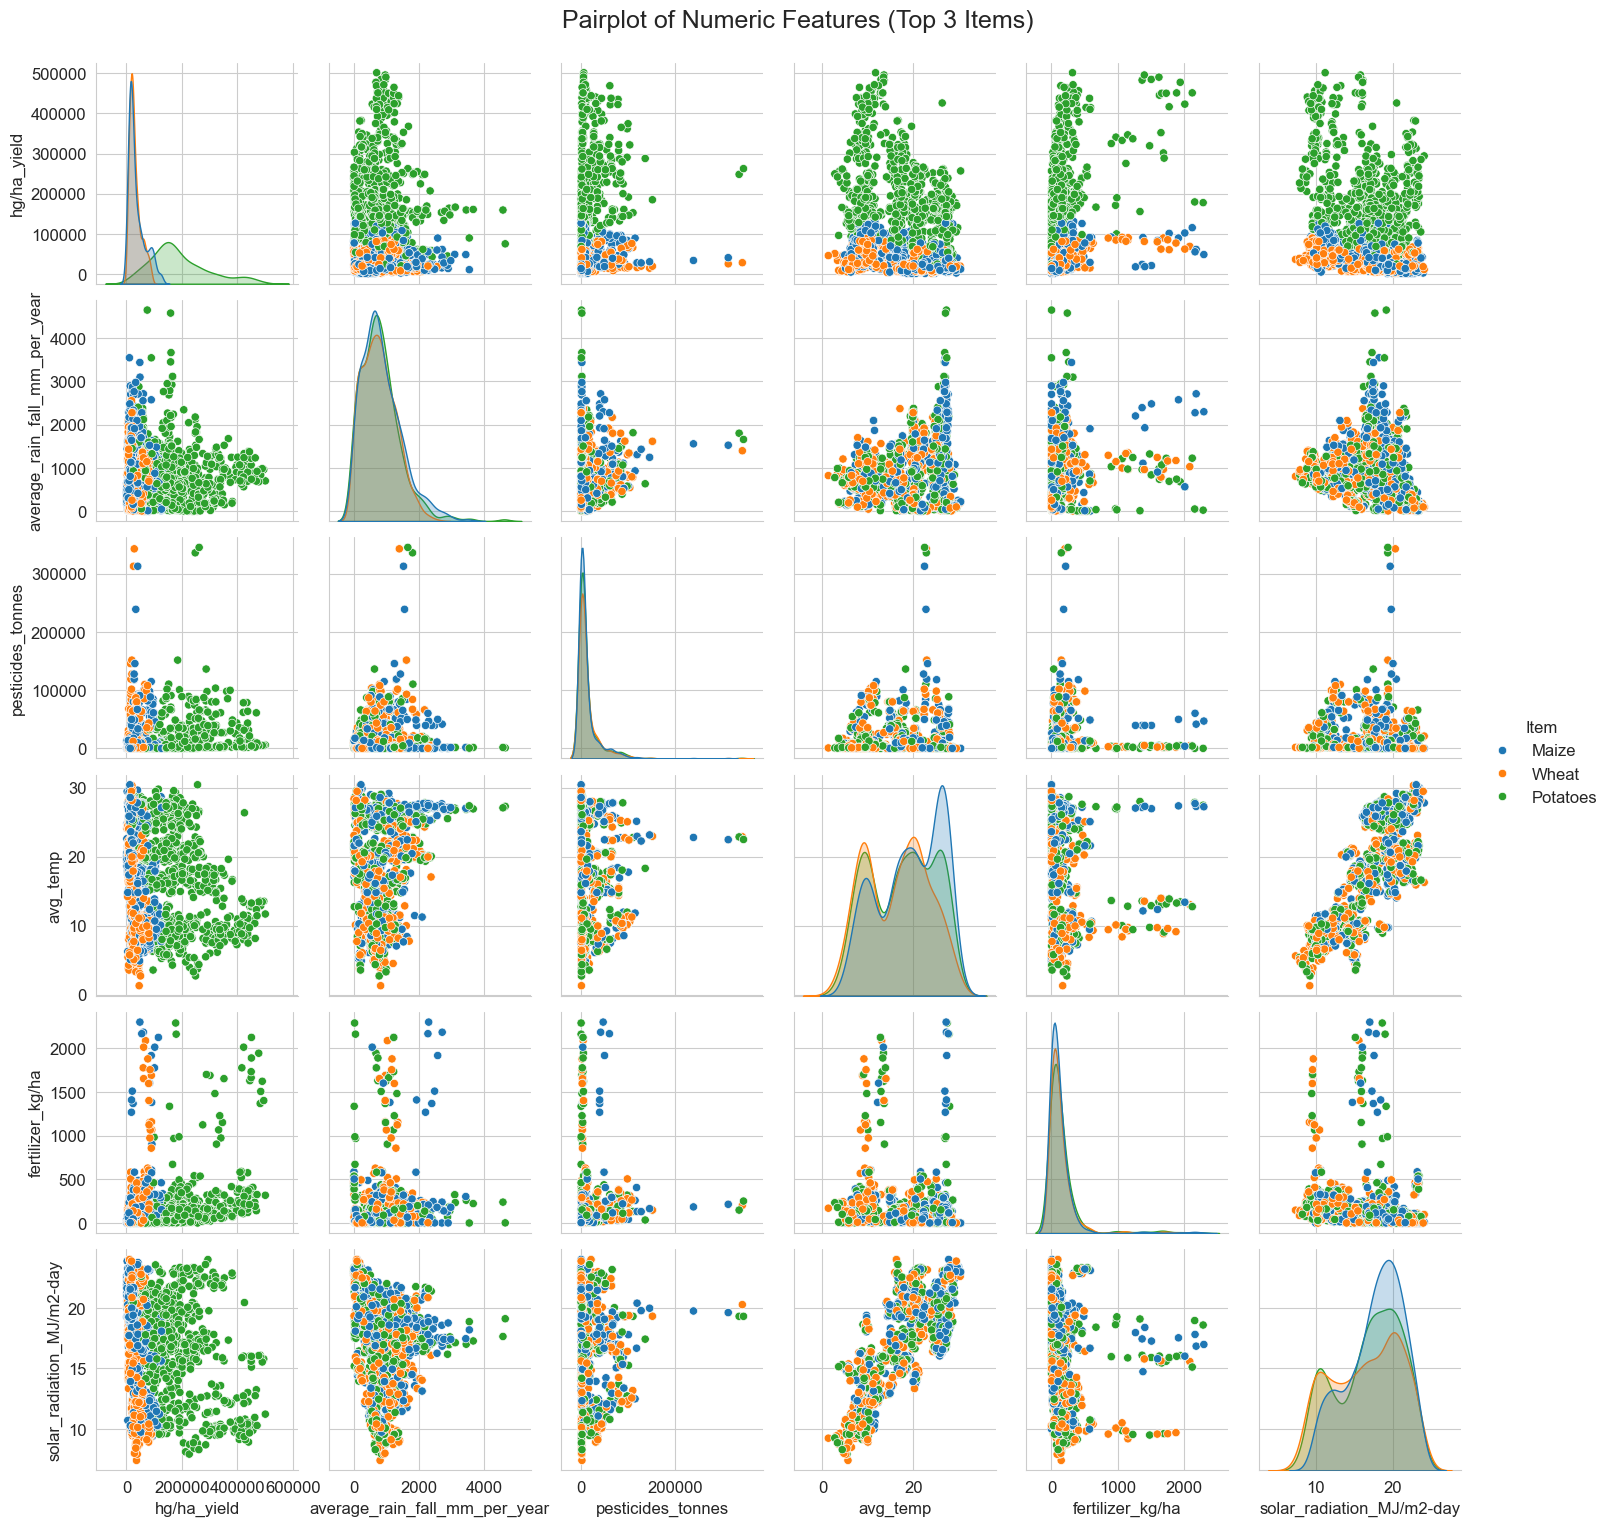

In [26]:
if not df.empty:
    print("Pairplot of all numeric features (using 5000 samples)")
    # Use a smaller sample for the pairplot as it's computationally intensive
    pairplot_sample = df_cleaned.sample(n=min(5000, df_cleaned.shape[0]), random_state=42)
    
    # Add 'Item' to see if we can color by a few categories
    # Let's find the top 3 items
    top_3_items = df_cleaned['Item'].value_counts().head(3).index
    pairplot_sample_filtered = pairplot_sample[pairplot_sample['Item'].isin(top_3_items)]

    sns.pairplot(pairplot_sample_filtered, vars=numeric_features, hue='Item', diag_kind='kde')
    plt.suptitle('Pairplot of Numeric Features (Top 3 Items)', y=1.02, fontsize=18)
    plt.show()

**Pairplot Interpretation:**

The pairplot provides a dense summary. By coloring by `Item`, we can see if different crops have different relationships. For instance, the `Yield vs. Fertilizer` relationship might be steeper for 'Maize' than for 'Wheat'. The KDE plots on the diagonal also show how the distributions of each feature differ by crop.

### 4.5. Yield by Category (Boxplots & Violin Plots)

Let's look at the *distribution* of yields for each item, not just the average.

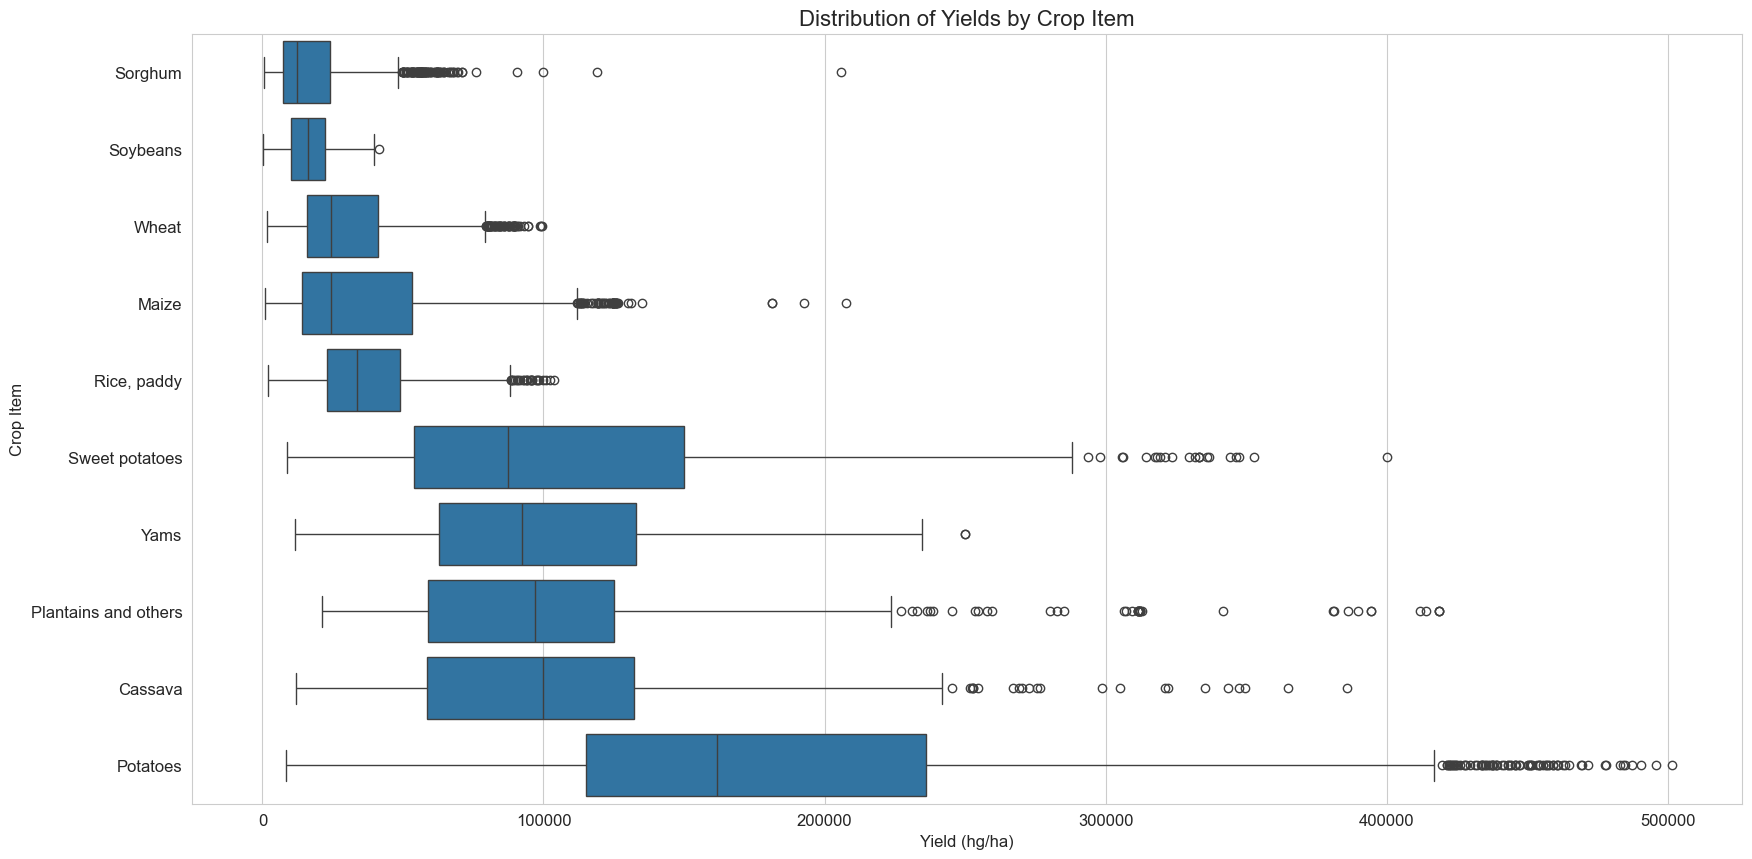

In [27]:
if not df.empty:
    plt.figure(figsize=(20, 10))
    # Sort items by median yield for a cleaner plot
    sorted_items = df_cleaned.groupby('Item')['hg/ha_yield'].median().sort_values().index
    
    sns.boxplot(data=df_cleaned, x='hg/ha_yield', y='Item', order=sorted_items)
    plt.title('Distribution of Yields by Crop Item', fontsize=16)
    plt.xlabel('Yield (hg/ha)', fontsize=12)
    plt.ylabel('Crop Item', fontsize=12)
    plt.show()

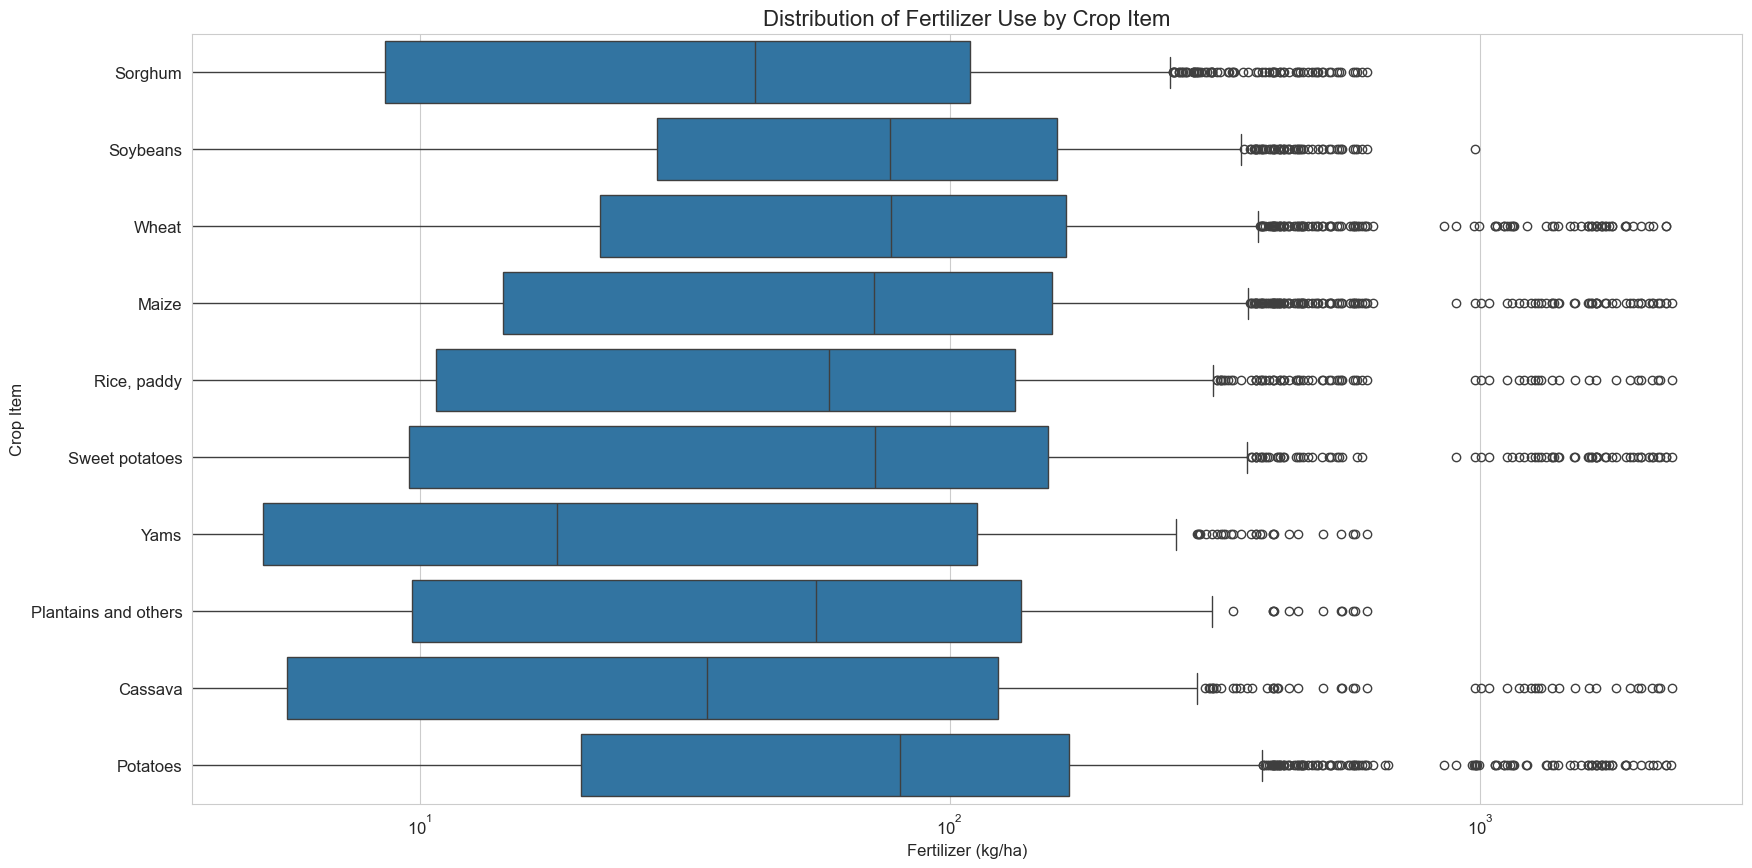

In [28]:
if not df.empty:
    # Let's see how fertilizer use varies by item
    plt.figure(figsize=(20, 10))
    # Use the same sorted_items index for consistency
    sns.boxplot(data=df_cleaned, x='fertilizer_kg/ha', y='Item', order=sorted_items)
    plt.title('Distribution of Fertilizer Use by Crop Item', fontsize=16)
    plt.xlabel('Fertilizer (kg/ha)', fontsize=12)
    plt.ylabel('Crop Item', fontsize=12)
    plt.xscale('log') # Use log scale due to high skew
    plt.show()

**Boxplot Interpretation:**

These plots are excellent. The first plot shows not just the average (median line) yield per crop, but also the variance (size of the box) and the outliers. 'Potatoes' and 'Maize' have high median yields but also a very wide range of outcomes.

The second plot, when compared to the first, is powerful. We can see that 'Maize' and 'Potatoes' not only have high yields, but also have the highest and most varied fertilizer application. This reinforces the link between fertilizer and yield.

### 4.6. Temporal Trends

How have these factors changed over time (from 1990 to 2013)?

In [29]:
if not df.empty:
    # Group by year and get the average of all numeric features
    yearly_avg = df_cleaned.groupby('Year')[numeric_features].mean().reset_index()

    fig = px.line(yearly_avg, x='Year', y='hg/ha_yield', 
                  title='Global Average Crop Yield Over Time', 
                  markers=True)
    fig.update_layout(xaxis_title='Year', yaxis_title='Average Yield (hg/ha)')
    fig.show()

In [30]:
if not df.empty:
    # Plot all key metrics over time
    fig = px.line(yearly_avg, x='Year', 
                  y=['hg/ha_yield', 'fertilizer_kg/ha', 'solar_radiation_MJ/m2-day', 'avg_temp', 'pesticides_tonnes'],
                  title='Global Average of Key Metrics Over Time',
                  facet_row='variable', 
                  markers=True)
    fig.update_layout(xaxis_title='Year', yaxis_title='Average Value')
    fig.update_yaxes(matches=None) # Unlink y-axes
    fig.show()

**Temporal Interpretation:**

* **`hg/ha_yield`**: There is a clear and steady *increase* in average global yield over time. This is a key finding.
* **`fertilizer_kg/ha`**: This also shows a steady *increase* over time, mirroring the trend in yield. This suggests technological improvements and more intensive farming are driving yields up.
* **`avg_temp`**: Shows a slight upward trend, consistent with global warming.
* **`solar_radiation_MJ/m2-day`**: Appears relatively stable with some cyclical variations.
* **`pesticides_tonnes`**: Shows a more dramatic increase, especially in the 2000s.

#### 4.6.1. Temporal Trends for Top 5 Items

Is this yield increase uniform across all crops?

In [31]:
if not df.empty:
    # Find top 5 items by total entries (most common data)
    top_5_items = df_cleaned['Item'].value_counts().head(5).index
    df_top_items = df_cleaned[df_cleaned['Item'].isin(top_5_items)]

    # Group by Year and Item
    yearly_avg_items = df_top_items.groupby(['Year', 'Item'])['hg/ha_yield'].mean().reset_index()

    fig = px.line(yearly_avg_items, x='Year', y='hg/ha_yield', color='Item', 
                  title='Average Yield Over Time for Top 5 Crops', 
                  markers=True)
    fig.update_layout(xaxis_title='Year', yaxis_title='Average Yield (hg/ha)')
    fig.show()

## 5. Feature Relationships & Insights

Let's consolidate what we've learned.

### 5.1. Top Predictors (by Correlation)

A simple bar chart of the correlation coefficients with yield can be very effective.

In [32]:
if not df.empty:
    # Get correlations with yield
    yield_corr = corr_matrix['hg/ha_yield'].drop('hg/ha_yield').sort_values(ascending=False)
    
    fig = px.bar(yield_corr, x=yield_corr.index, y=yield_corr.values,
                 title='Correlation with Yield (hg/ha)',
                 labels={'x': 'Feature', 'y': 'Pearson Correlation Coefficient'})
    fig.show()

### 5.2. Yearly Changes Analysis

We saw that fertilizer and yield *levels* are correlated. But is the *year-to-year change* in fertilizer use correlated with the *year-to-year change* in yield? This is a more advanced question.

--- Scatterplot of Yearly % Changes (Yield vs. Fertilizer) ---


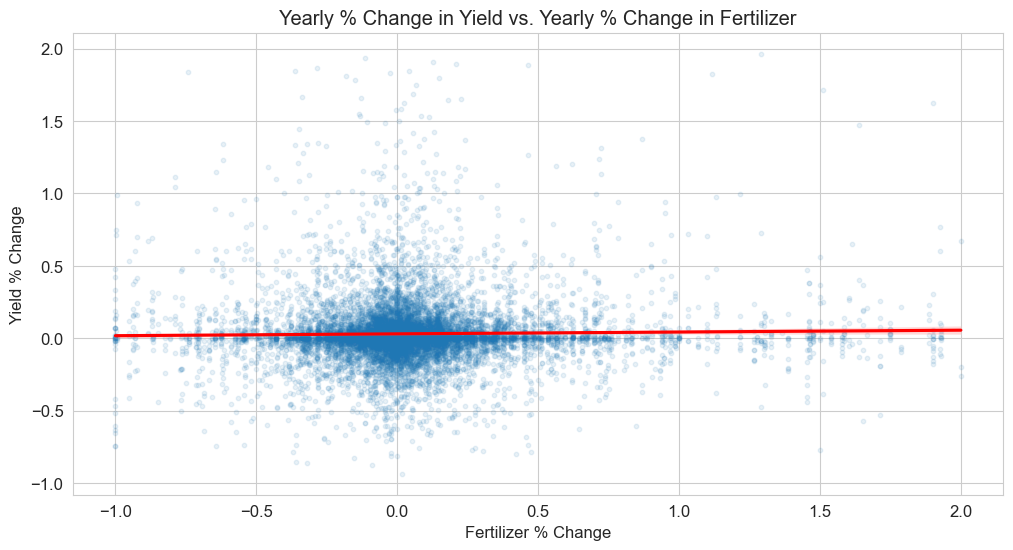

In [33]:
if not df.empty:
    # Sort data to ensure correct percentage change calculation
    df_sorted = df_cleaned.sort_values(by=['Area', 'Item', 'Year'])
    
    # Calculate percentage change grouped by Area and Item
    df_sorted['yield_pct_change'] = df_sorted.groupby(['Area', 'Item'])['hg/ha_yield'].pct_change()
    df_sorted['fertilizer_pct_change'] = df_sorted.groupby(['Area', 'Item'])['fertilizer_kg/ha'].pct_change()
    df_sorted['solar_pct_change'] = df_sorted.groupby(['Area', 'Item'])['solar_radiation_MJ/m2-day'].pct_change()
    
    # Drop NA values created by pct_change (the first year for each group)
    # Also replace infinite values that can occur from 0-to-X changes
    df_changes = df_sorted[['yield_pct_change', 'fertilizer_pct_change', 'solar_pct_change']]
    df_changes = df_changes.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    
    # Filter out extreme changes (e.g., > 200%)
    df_changes_filtered = df_changes[
        (df_changes['yield_pct_change'].abs() < 2) & 
        (df_changes['fertilizer_pct_change'].abs() < 2)
    ]
    
    print("--- Scatterplot of Yearly % Changes (Yield vs. Fertilizer) ---")
    sns.regplot(data=df_changes_filtered, x='fertilizer_pct_change', y='yield_pct_change', 
                scatter_kws={'alpha': 0.1, 's': 10}, line_kws={'color': 'red'})
    plt.title('Yearly % Change in Yield vs. Yearly % Change in Fertilizer')
    plt.xlabel('Fertilizer % Change')
    plt.ylabel('Yield % Change')
    plt.show()

**Yearly Change Interpretation:**

This plot is very interesting. The positive slope (though with high variance) suggests that in a given year, for a specific crop and area, an *increase* in fertilizer use (e.g., +10%) *is* associated with an *increase* in yield (e.g., +2%). This is a stronger piece of evidence than the simple level correlation, as it controls for the baseline values.

## 6. Summary of Key Insights & Export


### 6.1. Key Insights from EDA

1.  **Data is High Quality:** The dataset is largely complete and clean after minimal processing.
2.  **Yields are Increasing:** There is a clear, steady global trend of increasing crop yields from 1990-2013.
3.  **Fertilizer is a Key Driver:** `fertilizer_kg/ha` is the single strongest correlate of `hg/ha_yield` (r=0.64). This is supported by level analysis (high-yield crops use high fertilizer) and temporal analysis (both yield and fertilizer use are increasing over time).
4.  **Intensive Farming:** `fertilizer_kg/ha` and `pesticides_tonnes` are highly correlated (r=0.75), suggesting they are part of a combined 'intensive farming' approach.
5.  **New Features are Valuable:** The new `fertilizer_kg/ha` and `solar_radiation_MJ/m2-day` columns are both positively correlated with yield and provide significant explanatory power.
6.  **Complex Relationships:** The relationships between yield and `avg_temp` or `average_rain_fall` are not simple linear trends. They are likely quadratic (have an optimal 'peak') and are highly dependent on the specific `Item` and `Area`.

### 6.2. Export Cleaned Data

Finally, we'll save our cleaned, processed DataFrame for use in any future modeling tasks.

In [34]:
if not df.empty:
    try:
        df_cleaned.to_csv('cleaned_crop_data.csv', index=False)
        print("\nSuccessfully exported 'cleaned_crop_data.csv'.")
    except Exception as e:
        print(f"\nError exporting file: {e}")


Successfully exported 'cleaned_crop_data.csv'.


---